In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# Read all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [56]:
# Build the vocabulary of the characters and mapppings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [462]:
block_size = 3
X, Y = [], []
for w in words[:4]:

    print(f'word: {w}')
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

word: yuheng
... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
word: diondre
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
word: xavien
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e
vie ---> n
ien ---> .
word: jori
... ---> j
..j ---> o
.jo ---> r
jor ---> i
ori ---> .


In [58]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [211]:
# Build dataset, split into training, dev/validation and test splits
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])
        

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [59]:
C = torch.randn((27, 2))

In [60]:
C[5]

tensor([1.6111, 0.1612])

In [61]:
# Equivalent approach - Would use this in when input are encoded by n-dimensional vectors
# F = F.one_hot(torch.tensor(5), num_classes=27).float()
# F @ C
# tensor([ 0.2580 -0.2972])

In [62]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [63]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [64]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# torch.cat(torch.unbind(emb, 1), 1)
emb.view(emb.shape[0], block_size*2)

tensor([[-1.0442, -0.0089, -1.0442, -0.0089, -1.0442, -0.0089],
        [-1.0442, -0.0089, -1.0442, -0.0089,  1.6111,  0.1612],
        [-1.0442, -0.0089,  1.6111,  0.1612, -0.4082,  0.7913],
        ...,
        [-0.5969, -0.6095, -0.5969, -0.6095,  0.3676, -1.1268],
        [-0.5969, -0.6095,  0.3676, -1.1268, -0.5969, -0.6095],
        [ 0.3676, -1.1268, -0.5969, -0.6095, -0.2068,  0.7883]])

In [65]:
h = torch.tanh(emb.view(-1, block_size*2) @ W1 + b1)

In [66]:
h

tensor([[-0.7901, -0.5546,  0.9944,  ..., -0.9334, -0.9192, -0.8632],
        [-0.9604, -0.9923, -0.8720,  ...,  0.9976,  0.7301, -0.9911],
        [-0.8721,  0.7690, -0.8296,  ..., -0.9979,  1.0000,  0.8397],
        ...,
        [-0.9267, -0.9894, -0.5177,  ...,  0.9759, -0.9994, -0.9969],
        [-0.9475,  0.0304, -0.0340,  ..., -0.0745, -0.9951, -0.9878],
        [-0.9229, -0.2900, -0.9543,  ..., -0.3142, -0.9048, -0.8818]])

In [67]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [68]:
logits = h @ W2 + b2

In [69]:
logits.shape

torch.Size([228146, 27])

In [70]:
counts = logits.exp()

In [71]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [72]:
loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
loss

tensor(14.4223)

In [73]:
torch.arange(emb.shape[0])

tensor([     0,      1,      2,  ..., 228143, 228144, 228145])

In [74]:
prob[0]

tensor([8.4913e-08, 2.3591e-12, 2.8627e-13, 1.9134e-08, 1.1167e-05, 2.0587e-08,
        1.9584e-11, 3.5459e-10, 4.1896e-09, 4.7590e-10, 2.4540e-07, 3.9709e-04,
        9.9706e-01, 1.8093e-05, 1.1203e-06, 1.6077e-08, 1.1539e-10, 6.9408e-13,
        3.4383e-06, 1.1777e-06, 8.6520e-06, 7.4807e-12, 2.0067e-08, 1.3998e-04,
        2.3536e-03, 1.6150e-11, 2.9629e-07])

In [75]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [76]:
prob[0, 5]

tensor(2.0587e-08)

In [77]:
# For each of the 32 inputs, it returns the probability it assigned to the output from the training data
prob[torch.arange(emb.shape[0]), Y].shape

torch.Size([228146])

In [78]:
# ==== Overview ====

In [212]:
# Initialize the dataset
# Dataset, x = input, y = output
# input = number of inputs, block size
# output =number of outputs (equivalent to number of inputs)
Xtr.shape, Ytr.shape 

(torch.Size([182625, 3]), torch.Size([182625]))

In [463]:
# Initialize the neural network
emb_size = 10
input_layer_size = emb_size * block_size

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((input_layer_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [465]:
# Number of parameters in total
sum(p.nelement() for p in parameters)

11897

In [466]:
lri, lossi, stepsi = [], [], []

In [475]:
for i in range(200000):
    # Mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], input_layer_size) @ W1 + b1) # (32, 100) = (n of inputs, n of neurons)
    logits = h @ W2 + b2 # (32, 27) = (n of inputs, n of outputs)
    
    # ---------- Calculate the loss based on the the values we get from the last layer
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'Loss: {loss.item()}')
    # ----------
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepsi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.030228853225708


In [476]:
# Single forward pass to calculate the loss over the entire dataset
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], input_layer_size) @ W1 + b1) # (32, 100) = (n of inputs, n of neurons)
logits = h @ W2 + b2 # (32, 27) = (n of inputs, n of outputs)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1628482341766357

In [477]:
# Single forward pass to calculate the loss over the entire dataset
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], input_layer_size) @ W1 + b1) # (32, 100) = (n of inputs, n of neurons)
logits = h @ W2 + b2 # (32, 27) = (n of inputs, n of outputs)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1194944381713867

In [455]:
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:, 1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
# plt.grid('minor')

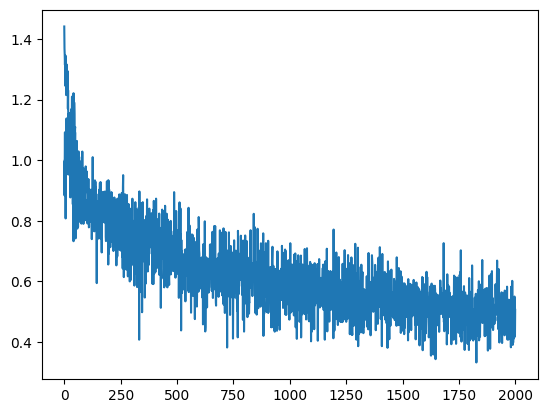

In [473]:
plt.plot(stepsi, lossi)

In [479]:
# Sample from model
g = torch.Generator().manual_seed(2147483647 + 20)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

rashamjwis.
koliarisa.
majius.
shaya.
khonaliannola.
tose.
jenanos.
amileah.
abig.
wan.
olia.
ani.
fadelizaie.
ann.
orianna.
vaewa.
kamalaien.
daryott.
camalaneiah.
adhera.
